# 10.  Use transfer learning for large image classification

_Exercise: Use transfer learning for large image classification, going through these steps:_

* _Create a training set containing at least 100 images per class. For example, you could classify your own pictures based on the location (beach, mountain, city, etc.), or alternatively you can use an existing dataset (e.g., from TensorFlow Datasets)._
* _Split it into a training set, a validation set, and a test set._
* _Build the input pipeline, including the appropriate preprocessing operations, and optionally add data augmentation._
* _Fine-tune a pretrained model on this dataset._

In [ ]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

In [ ]:
import tensorflow_datasets as tfds

from keras.api.layers import Conv2D, MaxPooling2D, InputLayer, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.api.models import Sequential, Model
from keras.api.applications.xception import Xception
from keras.api.optimizers import SGD, Nadam

import collections

import numpy as np

import matplotlib.pyplot as plt

2025-02-25 21:40:28.236000: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740516028.254565  166820 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740516028.260674  166820 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-25 21:40:28.280845: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
ds, info = tfds.load(
    "beans",
    split=["train", "validation", "test"],
    with_info=True,
    shuffle_files=True,
    as_supervised=True,
)

I0000 00:00:1740516030.994300  166820 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2874 MB memory:  -> device: 0, name: Quadro P600, pci bus id: 0000:01:00.0, compute capability: 6.1


In [3]:
n_classes = info.features["label"].num_classes
class_names = info.features["label"].names

In [4]:
ds_train = ds[0]
ds_valid = ds[1]
ds_test = ds[2]

In [5]:
print(len(list(ds_train)))
print(len(list(ds_valid)))
print(len(list(ds_test)))

2025-02-25 21:40:31.379696: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-02-25 21:40:31.943464: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-25 21:40:32.058687: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1034
133
128


In [6]:
info.description

'Beans is a dataset of images of beans taken in the field using smartphone\ncameras. It consists of 3 classes: 2 disease classes and the healthy class.\nDiseases depicted include Angular Leaf Spot and Bean Rust. Data was annotated by\nexperts from the National Crops Resources Research Institute (NaCRRI) in Uganda\nand collected by the Makerere AI research lab.'

In [7]:
ds_train

<_PrefetchDataset element_spec=(TensorSpec(shape=(500, 500, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [8]:
for image, label in ds_train.take(1):
  print(image.shape, label)

(500, 500, 3) tf.Tensor(1, shape=(), dtype=int64)


2025-02-25 21:40:32.291995: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
def count_labels(dataset):
    label_counts = collections.Counter()

    for _, label in dataset:
        label_counts[label.numpy()] += 1

    total_count = sum(label_counts.values())
    label_ratios = {label: count / total_count for label, count in label_counts.items()}
    
    sorted_label_ratios = dict(sorted(label_ratios.items()))

    return sorted_label_ratios

In [10]:
print(count_labels(ds_train))
print(count_labels(ds_valid))
print(count_labels(ds_test))

{0: 0.33365570599613154, 1: 0.3365570599613153, 2: 0.32978723404255317}
{0: 0.3308270676691729, 1: 0.3383458646616541, 2: 0.3308270676691729}
{0: 0.3359375, 1: 0.3359375, 2: 0.328125}


In [11]:
batch_size = 32
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])

preprocess_and_augmentation = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
    tf.keras.layers.RandomRotation(factor=0.05, seed=42),
    tf.keras.layers.RandomContrast(factor=0.2, seed=42),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])

In [12]:
ds_train = ds_train.map(
    lambda X, y: (preprocess_and_augmentation(X), y), num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(info.splits['train'].num_examples)
ds_train = ds_train.batch(batch_size)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

In [13]:
ds_valid = ds_valid.map(
    lambda X, y: (preprocess(X), y), num_parallel_calls=tf.data.AUTOTUNE)
ds_valid = ds_valid.cache()
ds_valid = ds_valid.batch(batch_size)
ds_valid = ds_valid.prefetch(tf.data.AUTOTUNE)

In [14]:
ds_test = ds_test.map(
    lambda X, y: (preprocess(X), y), num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.cache()
ds_test = ds_test.batch(batch_size)
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

In [15]:
for image, label in ds_train.take(1):
  print(image)

tf.Tensor(
[[[[-0.1791082  -0.3626197  -0.742144  ]
   [-0.39068568 -0.59340787 -0.9401126 ]
   [-0.5959693  -0.7877481  -1.        ]
   ...
   [-0.69983923 -0.40387273 -1.        ]
   [-0.72504616 -0.42511302 -1.        ]
   [-0.70972717 -0.41791326 -1.        ]]

  [[-0.15488577 -0.34528005 -0.72320557]
   [-0.25478208 -0.50118816 -0.8591892 ]
   [-0.41694087 -0.65512437 -0.97550106]
   ...
   [-0.5739782  -0.25520962 -0.92478573]
   [-0.67686784 -0.34305334 -0.9858951 ]
   [-0.77317905 -0.42858553 -1.        ]]

  [[-0.21754682 -0.3773951  -0.7587475 ]
   [-0.16224486 -0.40942538 -0.7469846 ]
   [-0.3200593  -0.5605978  -0.8831847 ]
   ...
   [-0.3664654  -0.05463564 -0.79447293]
   [-0.5209755  -0.18702763 -0.904339  ]
   [-0.6915369  -0.3408063  -1.        ]]

  ...

  [[-0.33387673  0.1508869  -0.37668347]
   [-0.37993157  0.09688973 -0.47553968]
   [-0.33640015  0.09922719 -0.49917728]
   ...
   [-0.07738876  0.19075489 -0.1936804 ]
   [-0.11046797  0.17441142 -0.21281034]
   [-

2025-02-25 21:40:35.405287: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


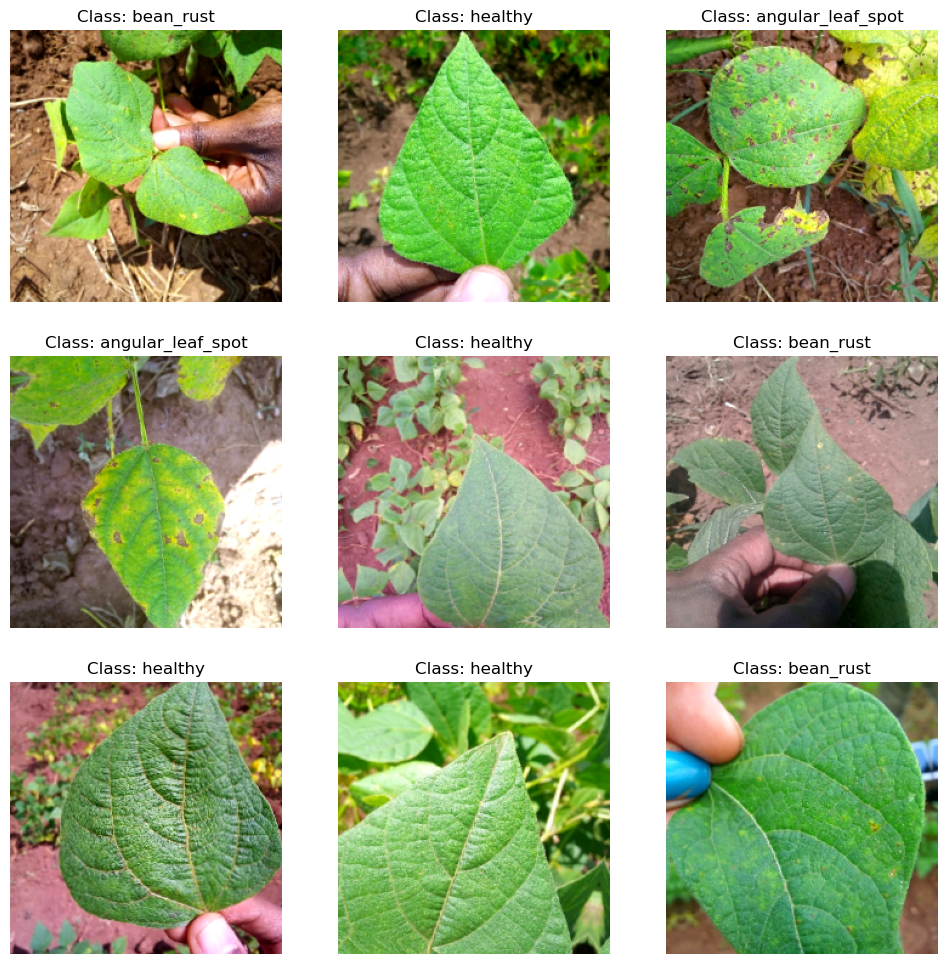

In [16]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in ds_train.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow((X_batch[index] + 1) / 2)  # rescale to 0–1 for imshow()
        plt.title(f"Class: {class_names[y_batch[index]]}")
        plt.axis("off")

plt.show()

In [17]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [27]:
base_model = Xception(weights="imagenet", include_top=False)
avg = GlobalAveragePooling2D()(base_model.output)
dropout = Dropout(0.25)(avg)
output = Dense(n_classes, activation="softmax")(dropout)
model = Model(inputs=base_model.input, outputs=output)

In [28]:
for layer in base_model.layers:
    layer.trainable = False

In [29]:
optimizer = SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(ds_train, validation_data=ds_valid, epochs=3)

Epoch 1/3
33/33 ━━━━━━━━━━━━━━━━━━━━ 30s 709ms/step - accuracy: 0.5328 - loss: 1.7421 - val_accuracy: 0.6842 - val_loss: 1.8088
Epoch 2/3
33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 514ms/step - accuracy: 0.7677 - loss: 1.2078 - val_accuracy: 0.5714 - val_loss: 3.9562
Epoch 3/3
33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 516ms/step - accuracy: 0.7031 - loss: 2.1019 - val_accuracy: 0.7895 - val_loss: 1.3045


4/4 - 2s - 469ms/step - accuracy: 0.8047 - loss: 1.5606
0.8046875


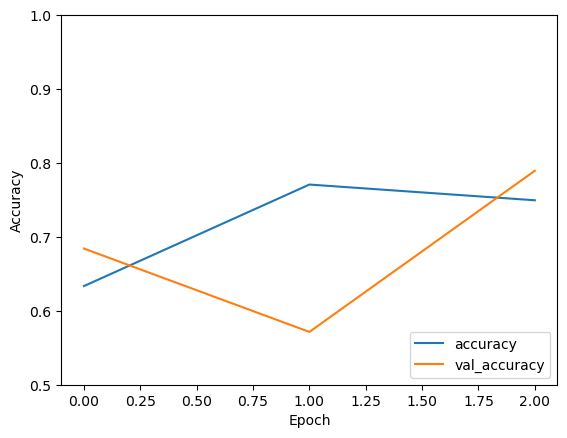

In [30]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(ds_test, verbose=2)
print(test_acc)

In [26]:
len(base_model.layers)

132

In [ ]:
for layer in base_model.layers[56:]:
    layer.trainable = True

optimizer = SGD(learning_rate=0.001, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(ds_train, validation_data=ds_valid, epochs=10)

Epoch 1/10


33/33 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.6996 - loss: 0.9961 - val_accuracy: 0.8120 - val_loss: 1.3255
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9314 - loss: 0.1662 - val_accuracy: 0.8346 - val_loss: 0.9827
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9717 - loss: 0.0754 - val_accuracy: 0.8872 - val_loss: 0.6844
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9966 - loss: 0.0286 - val_accuracy: 0.9098 - val_loss: 0.5896
Epoch 5/10
12/33 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9950 - loss: 0.0250

33/33 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9973 - loss: 0.0157 - val_accuracy: 0.9098 - val_loss: 0.4186

4/4 - 2s - 489ms/step - accuracy: 0.8750 - loss: 0.3236
0.875


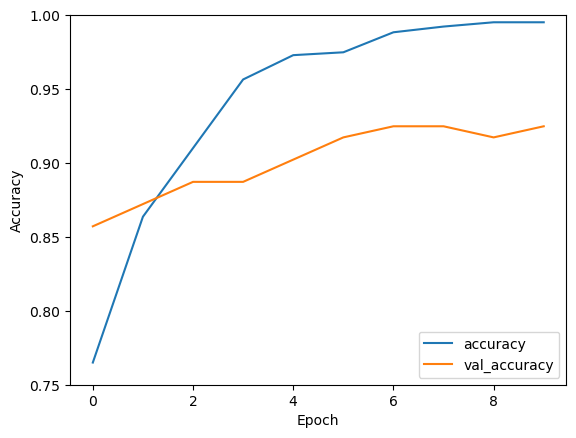

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.75, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(ds_test, verbose=2)
print(test_acc)

- accuracy without data augmentation or dropout: train: 1.00, validation: 0.9323, test: 0.9062
- accuracy with data augmentation but without dropout: train: 1.00, validation: 0.9549, test: 0.9062
- accuracy with data augmentation and dropout (0.25) : train: 0.9993, validation: 0.9549, test: 0.9453 